In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARMAResults
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet.diagnostics import cross_validation, performance_metrics
import xgboost as xgb
from xgboost import XGBRegressor
from filterpy.kalman import KalmanFilter
import tensorflow as tf
import warnings
from pathlib import Path

2025-03-12 16:29:47.551744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("data_daily.csv")

In [3]:
df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [4]:
df.dtypes

# Date           object
Receipt_Count     int64
dtype: object

In [5]:
df['Date'] = pd.to_datetime(df['# Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

df.drop("# Date",axis=1,inplace=True)

In [6]:
df

,Receipt_Count
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289
...,...
2021-12-27,10350408
2021-12-28,10219445
2021-12-29,10313337


In [7]:
df.tail()

,Receipt_Count
Date,
2021-12-27,10350408
2021-12-28,10219445
2021-12-29,10313337
2021-12-30,10310644
2021-12-31,10211187


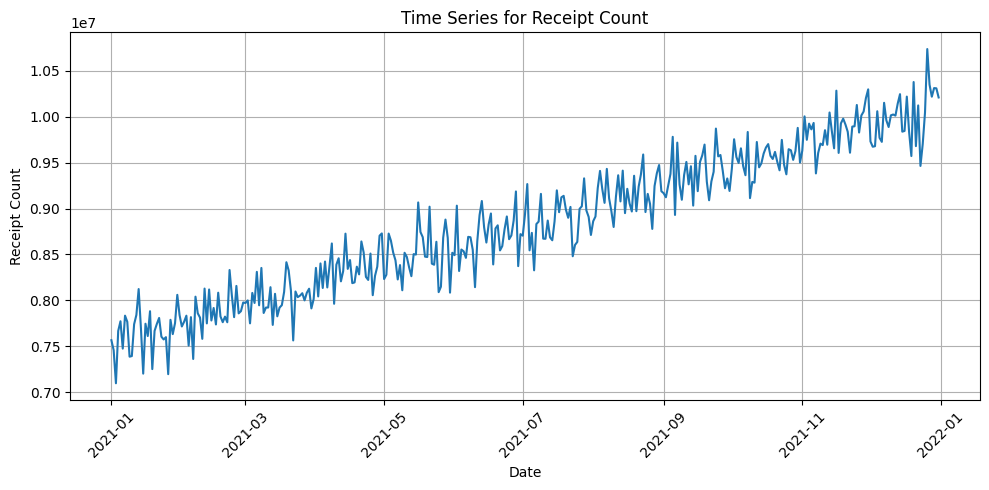

In [8]:
plt.figure(figsize=(10, 5))  # You can adjust the size of the figure
plt.plot(df['Receipt_Count'],  linestyle='-')  # Line plot with dots at data points
plt.title("Time Series for Receipt Count")
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated date labels
plt.show()

In [9]:
df['Receipt_Count'].isnull().sum()

0

In [10]:
df['Receipt_Count'].max()

10738865

In [11]:
df['Receipt_Count'].min()

7095414

In [12]:
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day  # Day of month
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.isocalendar().week.astype(int)
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_month_start'] = df.index.is_month_start.astype(int)
df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
df['is_quarter_start'] = df.index.is_quarter_start.astype(int)

In [13]:
# Define the country (example: United States)
us_holidays = holidays.US(years=2021)  # You can change this to holidays.CountryCode(years=2021) for other countries

# Create a National Holiday flag
df['Is_Holiday'] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

In [14]:
df['rolling_mean_7d'] = df['Receipt_Count'].rolling(window=7, min_periods=1).mean()
df['rolling_std_7d'] = df['Receipt_Count'].rolling(window=7, min_periods=1).std()
df['rolling_mean_28d'] = df['Receipt_Count'].rolling(window=28, min_periods=1).mean()

for lag in [1, 2, 7, 14, 28]:
    df[f'lag_{lag}'] = df['Receipt_Count'].shift(lag)

# Handle missing values from rolling/lag operations
df = df.fillna(method='bfill')

/var/folders/_5/5xzxgkc15jdg71sltgfrs8rm0000gn/T/ipykernel_18371/2644134416.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [15]:
for col in ['rolling_mean_7d', 'rolling_std_7d', 'rolling_mean_28d', 'lag_1',
       'lag_2', 'lag_7', 'lag_14', 'lag_28']:
    df[col] = df[col].astype('int32')

In [16]:
df.head()

,Receipt_Count,dayofweek,day,month,quarter,year,dayofyear,weekofyear,is_weekend,is_month_end,...,is_quarter_start,Is_Holiday,rolling_mean_7d,rolling_std_7d,rolling_mean_28d,lag_1,lag_2,lag_7,lag_14,lag_28
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,7564766,4,1,1,1,2021,1,53,0,0,...,1,1,7564766,77245,7564766,7564766,7564766,7564766,7564766,7564766
2021-01-02,7455524,5,2,1,1,2021,2,53,1,0,...,0,0,7510145,77245,7510145,7564766,7564766,7564766,7564766,7564766
2021-01-03,7095414,6,3,1,1,2021,3,53,1,0,...,0,0,7371901,245595,7371901,7455524,7564766,7564766,7564766,7564766
2021-01-04,7666163,0,4,1,1,2021,4,1,0,0,...,0,0,7445466,248714,7445466,7095414,7455524,7564766,7564766,7564766
2021-01-05,7771289,1,5,1,1,2021,5,1,0,0,...,0,0,7510631,260050,7510631,7666163,7095414,7564766,7564766,7564766


In [85]:
df.columns

Index(['Receipt_Count', 'dayofweek', 'day', 'month', 'quarter', 'year',
       'dayofyear', 'weekofyear', 'is_weekend', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start', 'Is_Holiday',
       'rolling_mean_7d', 'rolling_std_7d', 'rolling_mean_28d', 'lag_1',
       'lag_2', 'lag_7', 'lag_14', 'lag_28'],
      dtype='object')

In [99]:
df_xgb = df[['Receipt_Count', 'dayofweek', 'day', 'month', 'quarter', 'year',
       'dayofyear', 'weekofyear', 'is_weekend', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start', 'Is_Holiday']]

train = df_xgb.iloc[:-30]
test = df_xgb.iloc[-30:]

In [101]:
X_train, y_train = train.drop(columns=["Receipt_Count"], axis=1), train["Receipt_Count"]
X_test, y_test = test.drop(columns=["Receipt_Count"], axis=1), test["Receipt_Count"]

In [103]:
# Train and test xgboost model

matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_test = xgb.DMatrix(X_test, label = y_test)

In [105]:
# Run XGB 
model = xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                ,dtrain = matrix_train, num_boost_round = 500, 
                early_stopping_rounds = 20, evals = [(matrix_test,'test')],)

[0]	test-mae:956312.23333
[1]	test-mae:737971.23333
[2]	test-mae:551644.23333
[3]	test-mae:433441.10000
[4]	test-mae:342383.10000
[5]	test-mae:285715.90000
[6]	test-mae:257212.80000
[7]	test-mae:247147.13333
[8]	test-mae:240003.16667
[9]	test-mae:232185.00000
[10]	test-mae:227572.63333
[11]	test-mae:223855.96667
[12]	test-mae:223297.56667
[13]	test-mae:222388.66667
[14]	test-mae:220974.76667
[15]	test-mae:221411.23333
[16]	test-mae:221283.96667
[17]	test-mae:218159.43333
[18]	test-mae:218116.10000
[19]	test-mae:215468.53333
[20]	test-mae:215399.20000
[21]	test-mae:216454.86667
[22]	test-mae:216903.80000
[23]	test-mae:217494.63333
[24]	test-mae:217478.56667
[25]	test-mae:217510.53333
[26]	test-mae:217413.33333
[27]	test-mae:217931.46667
[28]	test-mae:218684.76667
[29]	test-mae:218028.46667
[30]	test-mae:220033.80000
[31]	test-mae:219367.66667
[32]	test-mae:219382.60000
[33]	test-mae:219382.60000
[34]	test-mae:219445.40000
[35]	test-mae:222315.76667
[36]	test-mae:222778.40000
[37]	test-m

model_v5 = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    n_estimators=500,
    early_stopping_rounds=20
)

model_v5.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
forecast_values_v5 = model_v5.predict(X_test)

model_v5 = xgb.XGBRegressor(
            objective='reg:squarederror',
            max_depth=6,              # Increased depth for more complex patterns
            learning_rate=0.05,       # Lower learning rate for better convergence
            n_estimators=500,         # More estimators for better performance
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,       # Controls model complexity
            gamma=0.1,                # Minimum loss reduction to create a new tree split
            reg_alpha=0.1,            # L1 regularization
            reg_lambda=1.0,           # L2 regularization
            random_state=42
        )

try:
    # Try with early_stopping_rounds parameter
    eval_set = [(X_test, y_test)]
    model_v5.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=30, verbose=False)
except TypeError:
    try:
        # Try with eval_metric parameter
        model_v5.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)
    except:
        # Fallback to basic fit
        model_v5.fit(X_train, y_train)

In [107]:
print(model.best_score)
print(model.best_iteration)

y_pred = model.predict(matrix_test, model.best_iteration)

215399.2
20


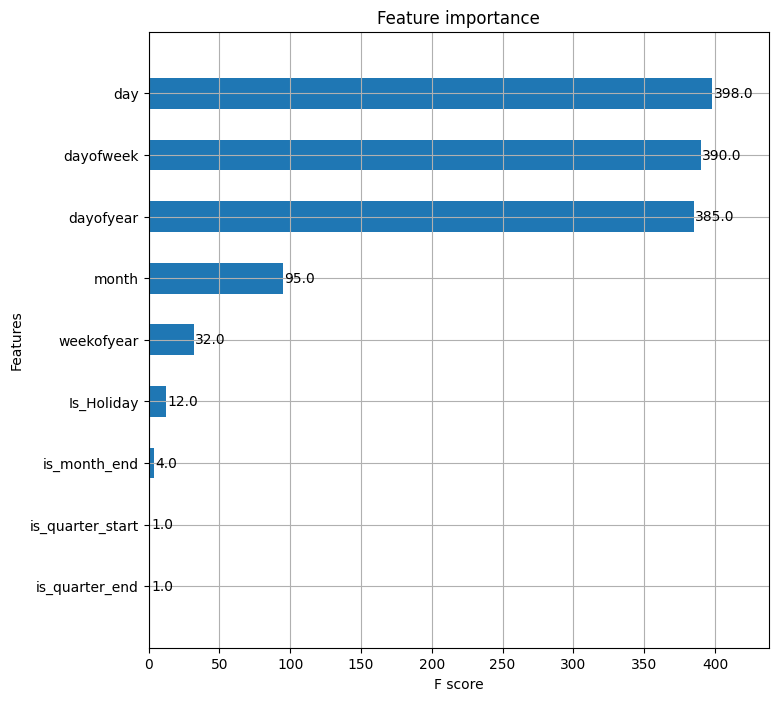

In [109]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, height=0.5, ax=ax);

In [111]:
def mape_calculation(test, forecast_values):
    # Extract the actual and forecast values from the DataFrame
    actual_values = test['Receipt_Count'].values
    forecast_values = forecast_values
    
    # Ensure both are one-dimensional arrays
    actual_values = np.squeeze(actual_values)
    forecast_values = np.squeeze(forecast_values)
    
    # Calculate the MAPE for each row
    mape_row_by_row = np.abs((actual_values - forecast_values) / actual_values) * 100
    
    # Create a DataFrame to display the row-by-row MAPE along with the actual and forecast values
    df_results = pd.DataFrame({
        'Actual': actual_values,
        'Forecast': forecast_values,
        'MAPE': mape_row_by_row
    })
    
    # Calculate the overall weighted MAPE
    weights = actual_values / actual_values.sum()
    overall_mape = np.sum(mape_row_by_row * weights)
    
    # Print the overall MAPE
    print(f"Overall MAPE: {overall_mape:.2f}%")

    title = 'XGBoost Predictions vs Actuals'
    ylabel='Receipts Count'
    
    ax = df_results['Actual'].plot(legend=True, figsize=(12, 6), title=title)
    df_results['Forecast'].plot(legend=True, ax=ax, linestyle='--')  # Make sure predictions plot on the same axis
    ax.autoscale(axis='x', tight=True)
    ax.set(ylabel=ylabel)
    
    # Set y-axis to start at zero
    #ax.set_ylim(bottom=0)  # This automatically adjusts the upper limit as needed
    
    plt.show();

Overall MAPE: 2.25%


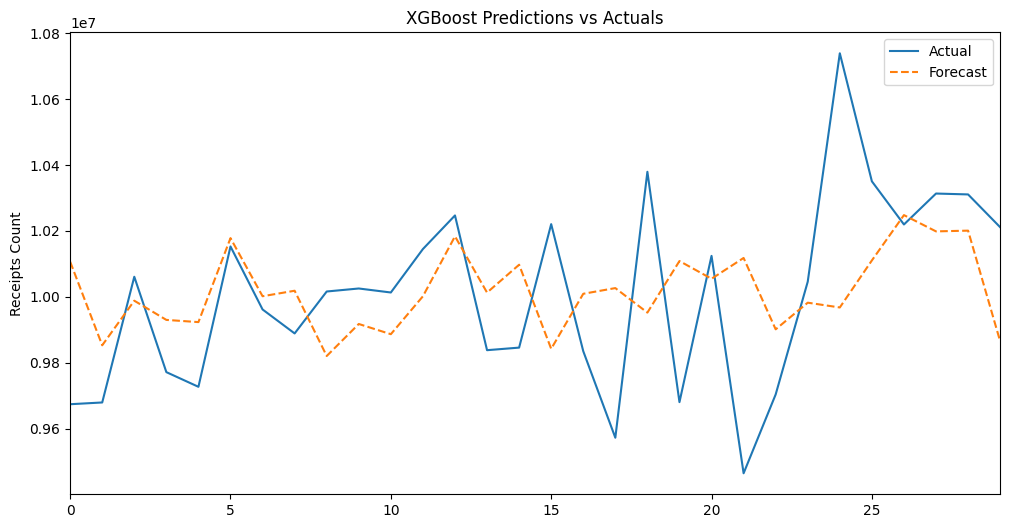

In [113]:
mape_calculation(test, y_pred)

In [115]:
rmse = np.sqrt(mean_squared_error(test['Receipt_Count'], y_pred))
mae = mean_absolute_error(test['Receipt_Count'], y_pred)
r2 = r2_score(test['Receipt_Count'], y_pred)

print(r2)
print(rmse)
print(mae)

-0.0621795654296875
289092.5693683599
224897.640625


In [117]:
# Direction accuracy (for trends)
direction_true = np.diff(test['Receipt_Count']) > 0
direction_pred = np.diff(y_pred) > 0
direction_accuracy = np.mean(direction_true == direction_pred)

direction_accuracy

0.4482758620689655

In [133]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df

,0
0,10106550.0
1,9852933.0
2,9988223.0
3,9929968.0
4,9923279.0
5,10178100.0
6,10001783.0
7,10018460.0
8,9820422.0
9,9917612.0


In [135]:
y_pred_df.to_csv('xgb_preds.csv')

In [85]:
df.columns

Index(['Receipt_Count', 'dayofweek', 'day', 'month', 'quarter', 'year',
       'dayofyear', 'weekofyear', 'is_weekend', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start', 'Is_Holiday',
       'rolling_mean_7d', 'rolling_std_7d', 'rolling_mean_28d', 'lag_1',
       'lag_2', 'lag_7', 'lag_14', 'lag_28'],
      dtype='object')

In [173]:
# Generate a DateTimeIndex for the entire year of 2022
future_dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
future_df = pd.DataFrame(index=future_dates)

future_df['dayofweek'] = future_df.index.dayofweek
future_df['day'] = future_df.index.day
future_df['month'] = future_df.index.month
future_df['quarter'] = future_df.index.quarter
future_df['year'] = future_df.index.year 
future_df['dayofyear'] = future_df.index.dayofyear
future_df['weekofyear'] = future_df.index.isocalendar().week.astype(int) 
future_df['is_weekend'] = (future_df.index.dayofweek >= 5).astype(int)
future_df['is_month_end'] = future_df.index.is_month_end.astype(int)
future_df['is_month_start'] = future_df.index.is_month_start.astype(int)
future_df['is_quarter_end'] = future_df.index.is_quarter_end.astype(int)
future_df['is_quarter_start'] = future_df.index.is_quarter_start.astype(int)

# Add Holiday Feature
us_holidays = holidays.US(years=2022)
future_df['Is_Holiday'] = future_df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

In [175]:
future_matrix = xgb.DMatrix(future_df)

# Make predictions using the trained model
future_predictions = model.predict(future_matrix)

In [200]:
future_df.iloc[0]['Receipt_Count'] - df.iloc[-1]['Receipt_Count']

139221.0

In [188]:
future_df['Receipt_Count'] = future_predictions + 2885287.0

In [190]:
future_df

,dayofweek,day,month,quarter,year,dayofyear,weekofyear,is_weekend,is_month_end,is_month_start,is_quarter_end,is_quarter_start,Is_Holiday,Receipt_Count
2022-01-01,5,1,1,1,2022,1,52,1,0,1,0,1,1,10350408.0
2022-01-02,6,2,1,1,2022,2,52,1,0,0,0,0,0,10204912.0
2022-01-03,0,3,1,1,2022,3,1,0,0,0,0,0,0,10496496.0
2022-01-04,1,4,1,1,2022,4,1,0,0,0,0,0,0,10592084.0
2022-01-05,2,5,1,1,2022,5,1,0,0,0,0,0,0,10531598.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1,27,12,4,2022,361,52,0,0,0,0,0,0,13090498.0
2022-12-28,2,28,12,4,2022,362,52,0,0,0,0,0,0,13071633.0
2022-12-29,3,29,12,4,2022,363,52,0,0,0,0,0,0,13080728.0
2022-12-30,4,30,12,4,2022,364,52,0,0,0,0,0,0,12848518.0


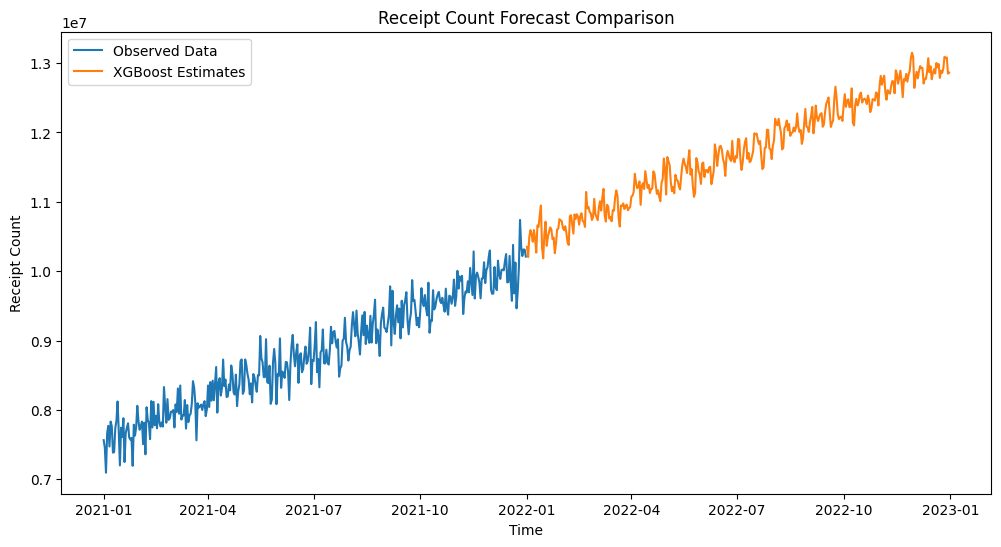

In [192]:
plt.figure(figsize=(12, 6))
#plt.plot(train['Receipt_Count'])
plt.plot(df['Receipt_Count'], label='Observed Data')
plt.plot(future_df['Receipt_Count'], label='XGBoost Estimates')
plt.title('Receipt Count Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()

In [202]:
# Generate a DateTimeIndex for the entire year of 2022
future_dates = pd.date_range(start='2022-01-01', end='2022-01-31', freq='D')
future_df = pd.DataFrame(index=future_dates)

future_df['dayofweek'] = future_df.index.dayofweek
future_df['day'] = future_df.index.day
future_df['month'] = future_df.index.month
future_df['quarter'] = future_df.index.quarter
future_df['year'] = future_df.index.year 
future_df['dayofyear'] = future_df.index.dayofyear
future_df['weekofyear'] = future_df.index.isocalendar().week.astype(int) 
future_df['is_weekend'] = (future_df.index.dayofweek >= 5).astype(int)
future_df['is_month_end'] = future_df.index.is_month_end.astype(int)
future_df['is_month_start'] = future_df.index.is_month_start.astype(int)
future_df['is_quarter_end'] = future_df.index.is_quarter_end.astype(int)
future_df['is_quarter_start'] = future_df.index.is_quarter_start.astype(int)

# Add Holiday Feature
us_holidays = holidays.US(years=2022)
future_df['Is_Holiday'] = future_df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

In [204]:
future_matrix = xgb.DMatrix(future_df)

# Make predictions using the trained model
future_predictions = model.predict(future_matrix)

In [224]:
diff = df.iloc[-1]['Receipt_Count'] - future_df.iloc[0]['Receipt_Count']

In [226]:
future_df['Receipt_Count'] = future_predictions + diff

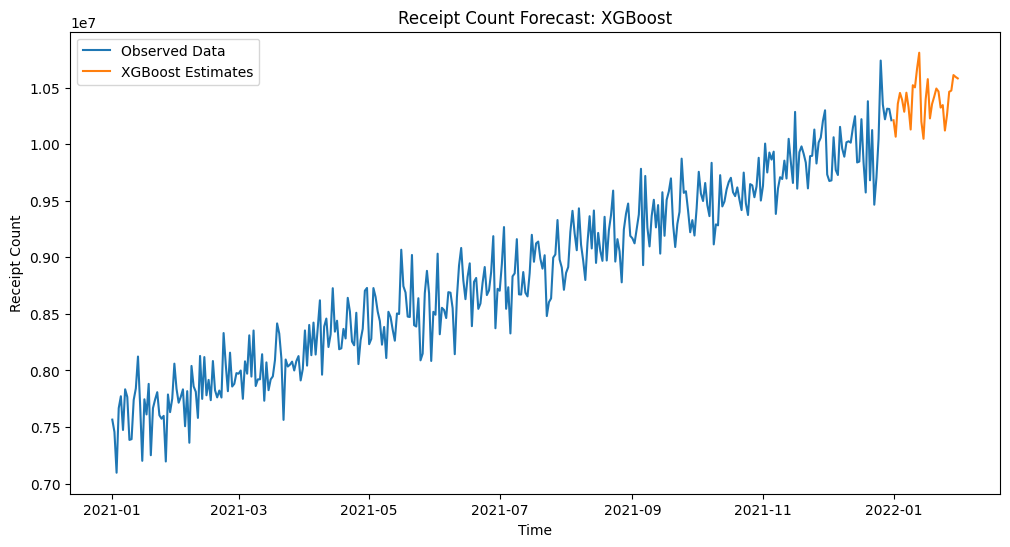

In [232]:
plt.figure(figsize=(12, 6))
#plt.plot(train['Receipt_Count'])
plt.plot(df['Receipt_Count'], label='Observed Data')
plt.plot(future_df['Receipt_Count'], label='XGBoost Estimates')
plt.title('Receipt Count Forecast: XGBoost')
plt.xlabel('Time')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()